## Keys and locks
### Introduction to secrets
The key to your home most likely opens a [tumbler lock](https://en.wikipedia.org/wiki/Pin_tumbler_lock#Design). Please take a close look at the figure: the grooves on a key are shaped to push the pins inside your lock so that they align precisely to allow the plug to rotate.

*A key contains the __information__* required to open a lock. In a tumbler lock key, this information is encoded in the depths of the grooves; the importance of the information content over the physical object it is encoded in is even more evident in a [combination lock](https://en.wikipedia.org/wiki/Combination_lock), where the key is a secret knowledge that only you should know - assuming you changed the combination from the default setting - but can be copied by shoulder-surfing any time you open the lock.

The space of all possible keys opening a lock is the possible heights of all pins. An attacker can either try all possible keys (brute force), make a copy of your key (bypass copy protection), or steal your key.

**Exercise**: suppose a friend decides to prank you by placing a combination lock on your gym locker. The lock has three decimal dials (0-9), with a combination unknown to you. Assuming it takes you one second to change the current combination and try to open the lock, how long would it take to try every possible combination to get your stuff back? Would you pay your friend a €5 ransom to tell you what the key is, and save you the time? What if the lock had four dials, instead of three?

## Hash-based message authentication codes (HMAC)

Shared secret keys can provide a means to verify authenticity of a message. A MAC is short tag $\mathfrak{m}$ attached to a message $m$. MAC algorithms consist of a tag generation $G$ and a tag verification algorithm $V$; these depend on the specific algorithm, but for example they might look like this:

$\begin{align*}
    G(m,k) &= \mathfrak{m} \\
    V(\mathfrak{m},m,k) &= \texttt{true / false}
\end{align*}$

The basic principle behind keyed hash-based message authentication codes ([HMAC](https://en.wikipedia.org/wiki/HMAC); see [FIPS 198-1](https://www.nist.gov/publications/keyed-hash-message-authentication-code-hmac-0)) is that if we concatenate a secret key with our message, then it will be infeasible for an attacker without knowledge of the key to produce a valid tag.

**Exercise**: choose a message $m$, a hash function $H$, and a key $k$. Compute $h=H(m)$, and $h_k = H(k||m)$. Suppose you send Bob $m$ and $h_k$. How can Bob verify that the message is intact and authentic? Does Bob know that it was really you, and only you, who sent $m$?

In [1]:
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives import hashes
import os

k = os.urandom(32)
m = 'What is the airspeed velocity of an unladen swallow?'.encode('utf-8')

digest = hashes.Hash(hashes.SHA256(), backend=default_backend())
digest.update(m)
h = digest.finalize()
print(h)
digest = hashes.Hash(hashes.SHA256(), backend=default_backend())
digest.update(k+m)
h_k = digest.finalize()
print(h_k)

b'\x8fH>\x18\xfa\xc6\xab\x80\xe5\x8f\xffA\xae7^r\x85\xb4\x1f\x86\xf4rU\x98\xbb\x8d\xb9<\xa3\x8f\xd2X'
b'Yl\xc3\x03\xa7\xd9\xb4\xa7\xff\r\xac\xeb\x91\xae\n`\x1e\x86$\x8c\xd7\xec\x1a\x94\x8a\xe1\xc3y\x8e\x86\x96\x18'


In practice, this simple description above is not secure against all attacks, so the standard specifies additional rules for padding of the key, and a second round of hashing, so in fact, assuming $k$ is of the right length for the hash function $H$,

$HMAC(m,k) = H\left\{ (k \oplus \mathtt{outer\_pad}) || H[(k \oplus \mathtt{inner\_pad}) || m] \right\}$

**Exercise**: compute the hmac of some message of your choice. Pick a secure hash function and use a random key of the same length of the digest.

**Exercise**: verify that the hmac is correct. Refer to the [documentation](https://cryptography.io/en/latest/hazmat/primitives/mac/) for options.

In [2]:
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives import hashes, hmac
import secrets
import os

with open('/usr/share/dict/words') as f:
    words = [word.strip() for word in f]
    words = ' '.join(secrets.choice(words) for i in range(50))

key = os.urandom(32)
h = hmac.HMAC(key, hashes.SHA256(), backend=default_backend())
h.update(words.encode('utf-8'))
tag = h.finalize()
print(tag)

# now verify this MAC is correct

b':\xd5\x8e\r\xb4\x10\xca[\xbb:\x12m\xc6\xf7\xd9\xa1\x12"\x80\x11Uw\x10/@\xaa\xc5\xdc\xb9\xf7$\xc7'


## Replay attacks
Suppose you want to use a MAC to authenticate the same message repeatedly. For example, you have a sensor reporting one of a small set of values. As soon as a message-MAC pair $(m,\mathrak{m})$ has been created, any eavesdropper knows what the value of the corresponding MAC, which will never change. A receiver will not know whether the MAC has been computed recently, or intercepted.



'Everything is under control. Situation normal. Had a slight weapons malfunction. But, uh, everything's perfectly all right now. We're fine. We're all fine here, now, thank you. How are you?'

**Exercise**: choose a message and initialize a counter. Increment the counter and concatenate its value with the message. Verify that the MAC for each message is different and presumably unpredictable.

# Cryptography

A cipher is a set of algorithms designed to provide **confidentiality** of a message, a.k.a. plaintext, by replacing it with a ciphertext.

Recall from the lectures:

> A cryptosystem is a 5-tuple (E,D,M,C,K) where
> * E is an encryption algorithm
> * D is a decryption algorithm
> * M is the set of plaintexts
> * C is the set of ciphertexts
> * K is the set of keys

> [Kerckhoffs’ principle](https://en.wikipedia.org/wiki/Kerckhoffs%27s_principle): do not rely on the secrecy of algorithms; the key should be the only secret that needs protection

> The strength of any cryptographic system rests with the key distribution technique

## Symmetric cryptography

A symmetric cipher uses the same key to encrypt and decrypt plaintext messages:

$
\begin{align*}
    E(k,p)=c \\
    D(k,c)=p
\end{align*}
$

### Substitution ciphers and frequency attacks
You've seen the Caesar and Vigenere ciphers in the lectures. Suppose your message alphabet has $L=26$ letters. All ciphers may be vulnerable to frequency attacks, but we can see this most clearly with simple substitution ciphers.

**Exercise**: pick an English text of your choice. For example, you can download a book from [project Gutenberg](https://www.gutenberg.org/) - but do please download whole books only once, saving a local copy so you don't abuse their servers unnecessarily. Display a bar chart or histogram of the counts of individual letters in the text. How does the text you chose compare with [letter frequency](https://en.wikipedia.org/wiki/Letter_frequency) statistics from wikipedia?
Now pick a random key, encrypt the text with the Caesar cipher, and repeat the graph.

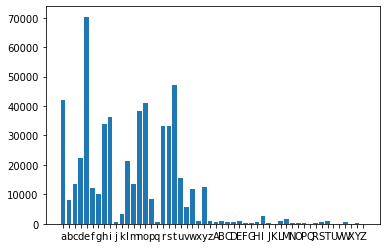

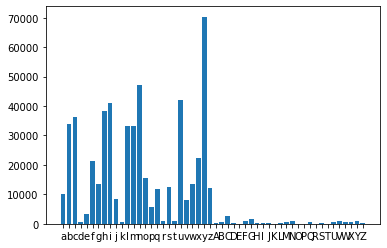

In [3]:
# https://www.gutenberg.org/files/1342/1342-0.txt
import string
import secrets
import os
from numpy import histogram
%matplotlib inline
import matplotlib.pyplot as pplt
from collections import Counter
from numpy import array

alphabet = string.ascii_letters
num_letters = int(len(alphabet)/2)

with open('1342-0.txt','r') as f:
    text = f.read()

counts = Counter(text)
letter_counts = []
for letter in alphabet:
    letter_counts.append(counts[letter])

pplt.bar(range(len(alphabet)), letter_counts, tick_label=list(alphabet))

pplt.show()

key = secrets.randbelow(num_letters)
lower_case = alphabet[0:num_letters]
upper_case = alphabet[num_letters:2*num_letters]

substitution = dict()

for letter in range(num_letters):
    new_letter = (letter+key)%num_letters
    substitution[lower_case[letter]] = lower_case[new_letter]
    substitution[upper_case[letter]] = upper_case[new_letter]

ciphertext = []
for j in range(len(text)):
    char = text[j]
    if char in alphabet:
        ciphertext.append(substitution[char])
    else:
        ciphertext.append(text[j])

counts = Counter(ciphertext)
letter_counts = []
for letter in alphabet:
    letter_counts.append(counts[letter])
pplt.bar(range(len(alphabet)), letter_counts, tick_label=list(alphabet))
pplt.show()

## Block ciphers
A **block cipher** operates on blocks of a **fixed length**. 

If the plaintext length is not an exact multiple of the block length, [padding](https://en.wikipedia.org/wiki/Padding_(cryptography)) is required.

If the plaintext is longer than a single block length, a [mode of operation](https://en.wikipedia.org/wiki/Block_cipher_mode_of_operation) specifies precisely how repeated application of the block cipher will generate the final ciphertext - see [SP 800-38A](https://csrc.nist.gov/publications/detail/sp/800-38a/final).

The current standard for symmetric block ciphers is [AES](https://en.wikipedia.org/wiki/Advanced_Encryption_Standard) - see [FIPS 197](https://www.nist.gov/publications/advanced-encryption-standard-aes).

Let's look at some symmetric encryption examples with [cryptography.io](https://cryptography.io/en/latest/hazmat/primitives/symmetric-encryption/).

**Exercise**: encrypt a 128-bit message $m$ with AES-128.

In [7]:
from cryptography.hazmat.primitives import padding
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.backends import default_backend
import os
import secrets

backend = default_backend()

## generate a cryptographically secure random key
key = os.urandom(16)

## specify the cipher we want to use
cipher = Cipher(algorithms.AES(key), modes.ECB(), backend=backend)

## prepare to encrypt a message
encryptor = cipher.encryptor()

# generate a 16-byte message with random words / XKCD-style passphrase https://xkcd.com/936/
with open('/usr/share/dict/words') as f:
    words = [word.strip() for word in f]
    words = ' '.join(secrets.choice(words) for i in range(4))
    
# crop to block length for demonstration
plaintext = words[0:16]
print('plaintext: {0}, length: {1}'.format(plaintext, len(plaintext) ))

# pad message
padder = padding.PKCS7(128).padder()
m = padder.update(plaintext.encode('utf-8'))
m += padder.finalize()
print('Padded plaintext length: {0}'.format(len(m)))

#encrypt message
ciphertext = encryptor.update(m) + encryptor.finalize()
print('Ciphertext: {0}, length: {1}'.format(ciphertext, len(ciphertext)))

# decrypt message
decryptor = cipher.decryptor()
d = decryptor.update(ciphertext) + decryptor.finalize()

# remove padding
unpadder = padding.PKCS7(128).unpadder()
decrypted = unpadder.update(d)+unpadder.finalize()
print('Decrypted text: {0}'.format(decrypted.decode("utf-8")))

plaintext: serpentine bouto, length: 16
Padded plaintext length: 32
Ciphertext: b'\xa7H\xdaK \x9c\xf9e+\xd7\xf1\xa4]yX8\xddI\xe7\x9a\xb4f\x8e\x0c[\xc2\xb7\x94\x8eZ\n^', length: 32
Decrypted text: serpentine bouto


**Exercise**: try changing a single letter of the message or the key, and verify that the ciphertext changes completely.

## ECB mode
Perhaps the simplest mode of operation is known as [electronic codebook](https://en.wikipedia.org/wiki/Block_cipher_mode_of_operation#Electronic_Codebook_(ECB)) (ECB). Each block of plaintext is encrypted independently of the others, in parallel.

![ECB mode](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d6/ECB_encryption.svg/601px-ECB_encryption.svg.png)

**Exercise**: choose a 128-bit message. Concatenate the same 128-bit message with itself, and verify that using ECB mode the ciphertext is also repeated. An eavesdropper may not be able to tell what the message was, but they can tell the two parts were identical.

**Exercise**: (optional but illustrative) to see at a glance why this is a problem, try replicating the famous [ECB penguin](https://blog.filippo.io/the-ecb-penguin/) example (see this article on [ECB mode](https://en.wikipedia.org/wiki/Block_cipher_mode_of_operation#ECB)). Hint: the following code to get you started downloads an image file from a url and saves it in [PPM](https://en.wikipedia.org/wiki/Netpbm_format) format.

(196, 216)
b'\xfe\xfe\xfc\xfe\xfe\xfc\xfe\xfe\xfc\xfe'


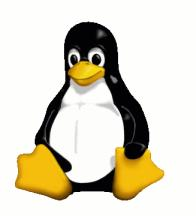

Plaintext length: 42336
Unpadded plaintext length: 127008
Padded plaintext length: 127024


In [5]:
import requests
import IPython.display as Disp
import numpy
from PIL import Image
import matplotlib.pyplot as pplt
from io import BytesIO

backend = default_backend()

# repeat the encryption steps above, using the penguin image as plaintext
# but note well: you will only be able to visualize the effect if each 
key = os.urandom(16)
cipher = Cipher(algorithms.AES(key), modes.ECB(), backend=backend)
encryptor = cipher.encryptor()

url = 'https://upload.wikimedia.org/wikipedia/commons/5/56/Tux.jpg'
r = requests.get(url)
#img = Disp.Image(r.content)
#print('w: {0}, h: {1}'.format(img.width, img.height))

img = Image.open(BytesIO(r.content))

pixel_data = list(img.getdata())
print(img.size)
img.save('temp.ppm')
a = Image.open('temp.ppm')
print(a.tobytes()[0:10])
Disp.display(a)

print('Plaintext length: {0}'.format(len(pixel_data)))

padder = padding.PKCS7(128).padder()
p = padder.update(a.tobytes())
q = len(p)
print('Unpadded plaintext length: {0}'.format(q))
p += padder.finalize()
print('Padded plaintext length: {0}'.format(len(p)))
ct = encryptor.update(p) + encryptor.finalize()

## CBC mode
In [cipher block chaining](https://upload.wikimedia.org/wikipedia/commons/thumb/8/80/CBC_encryption.svg/601px-CBC_encryption.svg.png) (CBC) mode, each block of ciphertext is XORed with the next block of plaintext before encryption: ![CBC mode](https://upload.wikimedia.org/wikipedia/commons/thumb/8/80/CBC_encryption.svg/601px-CBC_encryption.svg.png)
This is a serial mode of operation; encryption cannot be sped up by parallelizing tasks.

**Exercise**: pick a message of the same length as the block cipher. Concatenate the message with itself two or more times. Encrypt the plaintext using a block cipher in CBC mode, and verify that the corresponding ciphertext blocks are different, unlike ECB mode.

## Cipher-based MAC (CMAC)
Ciphers are designed to provide confidentiality. ECB and CBC mode are examples.

Ciphers do *not* provide integrity or authenticity of a message by themselves, unless used in a specific mode of operation designed to guarantee those properties.

The only currently approved mode of operation designed to provide integrity and authenticity is [cipher-based message authentication code (CMAC)](https://en.wikipedia.org/wiki/One-key_MAC). ![CMAC](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e2/CMAC_-_Cipher-based_Message_Authentication_Code.pdf/page1-800px-CMAC_-_Cipher-based_Message_Authentication_Code.pdf.jpg)

**Exercise**: compute the CMAC of the same message you used for the HMAC exercise above. Refer to the [documentation](https://cryptography.io/en/latest/hazmat/primitives/mac/cmac/?highlight=CMAC) for relevant functions.

## Authenticated encryption
Ciphers are designed to provide confidentiality - but they do *not* provide integrity or authenticity of a message by themselves, unless used as part of a more complex algorithm. [Authenticated Encryption](https://en.wikipedia.org/wiki/Authenticated_encryption) is designed to do just that. One method to achieve authenticated encryption is to *encrypt-then-MAC*.

More generally, a class of algorithms known as authenticated encryption with associated data (AEAD) has been identified in order to provide a flexible combination of confidentality and authenticity - in that some data are encrypted, some are not, and all are authenticated.

For example, the AES-GCM (see [SP 800-38d](https://csrc.nist.gov/publications/detail/sp/800-38d/final)).

**Exercise**: encrypt and decrypt a message and some associated data using AES-GCM. Refer to the [documentation](https://cryptography.io/en/latest/hazmat/primitives/aead/#cryptography.hazmat.primitives.ciphers.aead.AESGCM) for details. Check that changing the associated data in decryption leads to an error.

In [17]:
import os
from cryptography.hazmat.primitives.ciphers.aead import AESGCM
data = 'a secret message'.encode('utf-8')
aad = 'authenticated but unencrypted data'.encode('utf-8')
key = AESGCM.generate_key(bit_length=128)
aesgcm = AESGCM(key)
# AESGCM requires a nonce. You will have to choose its length!
# encrypt
# decrypt

## Standards
[Key management](https://csrc.nist.gov/Projects/Key-Management/Key-Management-Guidelines) is critical to the security of any application.

Lists of government-approved algorithms, parameters, and key sizes for cryptography are maintained by [NIST](https://csrc.nist.gov/projects/block-cipher-techniques) and [ENISA](https://www.enisa.europa.eu/publications/algorithms-key-size-and-parameters-report-2014).

A list of approved [block cipher modes of operation](https://csrc.nist.gov/projects/block-cipher-techniques/bcm/current-modes) is maintained by NIST.
> Currently, NIST has approved fourteen modes of the approved block ciphers in a series of special publications. As summarized on the [Current Modes](https://csrc.nist.gov/projects/block-cipher-techniques/bcm/current-modes) page, there are eight confidentiality modes (ECB, CBC, OFB, CFB, CTR, XTS-AES, FF1, and FF3), one authentication mode (CMAC), and five combined modes for confidentiality and authentication (CCM, GCM, KW, KWP, and TKW).

# Theme
You can run the following cell to change the appearance of this notebook to suit your taste. Check for available themes on [github.com/dunovank/jupyter-themes](https://github.com/dunovank/jupyter-themes).

In [8]:
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('solarizedl')